## Studying the patterns that determine the success of games

It is necessary to identify patterns that determine the success of the game. This will allow you to bid on a potentially popular product and plan advertising campaigns.

**Data**

- *Name* — game name
- *Platform* — the platform on which the game is implemented
- *Year_of_Release* — the year when the game was released
- *Genre* — game genre
- *NA_sales* — sales in North America (millions of dollars)
- *EU_sales* — sales in Europe (millions of dollars)
- *JP_sales* — sales in Japan (millions of dollars)
- *Other_sales* — sales in other countries (millions of dollars)
- *Critic_Score* — Critics score (max 100)
- *User_Score* — user score (maximum 10)
- *Rating* — rating from the ESRB (Entertainment Software Rating Board).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st

### Data preprocessing

In [2]:
games_data = pd.read_csv('/datasets/games.csv')
games_data.info()
display(games_data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Let's preprocess the data. Let's replace the gaps, convert the data type in the columns to a more acceptable form (for example, years to integer). Let's convert the column names to lower case. We categorize the age rating by age, as a number.

In [3]:
games_data.columns = [x.lower() for x in games_data.columns] 
# converting column names to lowercase
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
display(games_data.corr())
games_data = games_data.dropna(axis='index', how='any', subset=['name'])
games_data.info()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
year_of_release,1.000000,-0.092500,0.003978,-0.168366,0.037820,0.011411
na_sales,-0.092500,1.000000,0.765335,0.449594,0.638649,0.240755
eu_sales,0.003978,0.765335,1.000000,0.435061,0.722792,0.220752
jp_sales,-0.168366,0.449594,0.435061,1.000000,0.291089,0.152593
other_sales,0.037820,0.638649,0.722792,0.291089,1.000000,0.198554
critic_score,0.011411,0.240755,0.220752,0.152593,0.198554,1.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


For gaps in the title of the games, deleted the lines, since 2 gaps are only 0.012% of the total amount of data

In [5]:
games_data['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

In [9]:
def rating_func(row): # function to categorize by age rating
    rat = row['rating']
    
    if rat ==  'EC':
        return 3
    if rat == 'E' or rat == 'K-A':
        return 6
    if rat == 'E10+':
        return 10
    if rat == 'T':
        return 13
    if rat == 'M':
        return 17
    if rat == 'AO':
        return 18
    if rat == 'unknown' or rat == 'RP':
        return -1
        
games_data['age_rating'] = games_data.apply(rating_func, axis=1)

print(games_data['age_rating'].value_counts())

 6.0     3993
 13.0    2961
 17.0    1563
 10.0    1420
 3.0        8
-1.0        3
 18.0       1
Name: age_rating, dtype: int64


Translated the rating for games into age values. (age taken from Wikipedia for the ESRB system)

In [10]:
games_data['rating'] = games_data['rating'].fillna('unknown')
games_data['year_of_release'] = games_data['year_of_release'].fillna(-1)
games_data['year_of_release'] = games_data['year_of_release'].astype('int')

games_data['user_score'] = games_data['user_score'].replace('tbd', np.nan)
games_data['user_score'] = games_data['user_score'].astype('float')

games_data['total_sales'] = games_data['na_sales'] + games_data['eu_sales'] + games_data['jp_sales'] + games_data['other_sales']

print(games_data['total_sales'].describe())

def sales_func(row): # function to categorize by income
    inc = row['total_sales']
    
    if inc < 0.06:
        return 'ниже первого квантиля'
    if inc < 0.17:
        return 'ниже медианы'
    if inc < 0.47:
        return 'ниже третьего квантиля'
    if inc < 0.53:
        return 'ниже среднего'
    if inc >= 0.53:
        return 'выше среднего'
        
games_data['sales_category'] = games_data.apply(sales_func, axis=1)
print(games_data['sales_category'].value_counts())


sales_type_list = ('выше среднего','ниже медианы', 'ниже первого квантиля','ниже среднего','ниже третьего квантиля')

for sales in sales_type_list: # gap replacement by column average, data grouped by gaming revenue
    games_data.loc[games_data['sales_category'] == sales, 'critic_score'] = \
    games_data.loc[games_data['sales_category'] == sales, 'critic_score'].\
    fillna(games_data.query('sales_category == @sales')['critic_score'].mean())
    
    games_data.loc[games_data['sales_category'] == sales, 'user_score'] =\
    games_data.loc[games_data['sales_category'] == sales, 'user_score'].\
    fillna(games_data.query('sales_category == @sales')['user_score'].mean())
    
print(games_data.info())
    

count    16713.000000
mean         0.533315
std          1.548282
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: total_sales, dtype: float64
ниже медианы              4422
ниже третьего квантиля    4151
ниже первого квантиля     3938
выше среднего             3809
ниже среднего              393
Name: sales_category, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 14 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null float64
user_score         16713 non-null float64
rating             16713 non-null object
age_rating         9949 non-null fl

For the age rating, the missing values were replaced with "unknown"

For the year of manufacture by -1, since it will not be possible to replace the average

Changed the value of tbd (to be determined) to Nan. To replace gaps in ratings from players and critics, I categorized by total revenue from the game, then calculated the average rating by revenue categories and replaced the gaps. Categories were taken from the calculation of revenue quantiles. The average rating was grouped by revenue, as there is little direct relationship between sales and rating.

I also replaced the user rating type with a real one, since the rating is a number.

For the year of issue, the data type was replaced with an integer


Since it will not be possible to find out the year of issue, and it will also be incorrect to replace the values with averages or medians, we will remove these gaps, since they make up 1.6% of the total data, which is not a very significant data removal

### Exploratory Analysis

count      37.000000
mean      444.432432
std       451.604334
min         9.000000
25%        36.000000
50%       338.000000
75%       762.000000
max      1427.000000
Name: name, dtype: float64


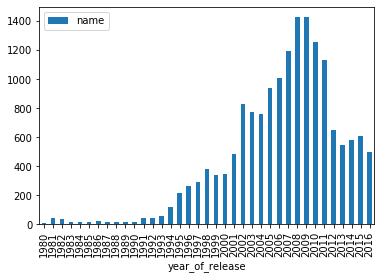

,year_of_release,name
1,1981,46
11,1991,41
12,1992,43
13,1993,60
14,1994,121
15,1995,219
16,1996,263
17,1997,289
18,1998,379
19,1999,338


In [11]:
games_data_year = games_data.query('year_of_release > 0') # selection of data in which the year is indicated
sales_by_year = games_data_year.groupby('year_of_release')['name'].count().reset_index()
sales_by_year.plot(kind='bar', y='name', x='year_of_release', legend=True)
print(sales_by_year['name'].describe())
plt.show()
sales_by_year = sales_by_year.query('name > 36')
display(sales_by_year)

Based on the first quintile, we will limit the years with the release of games over 36

['3DS', 'PSP', 'GBA', 'PS4', 'PS', 'DS', 'Wii', 'PS3', 'X360', 'PS2']


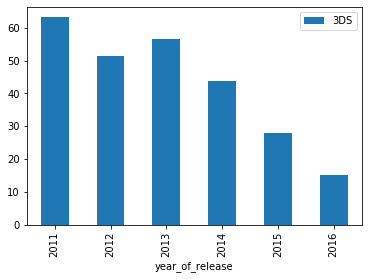

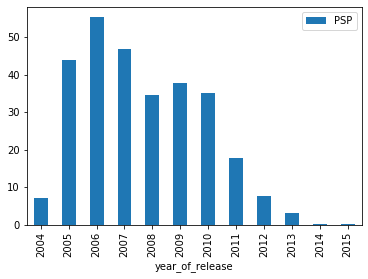

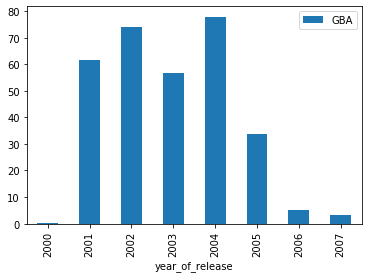

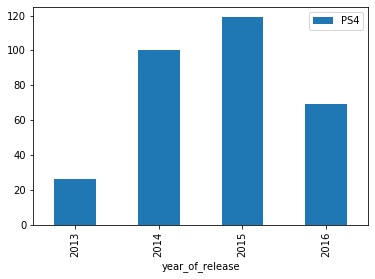

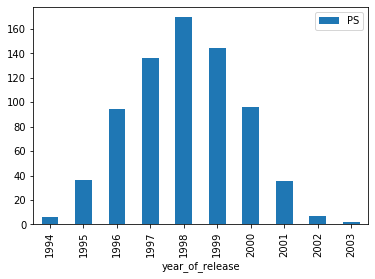

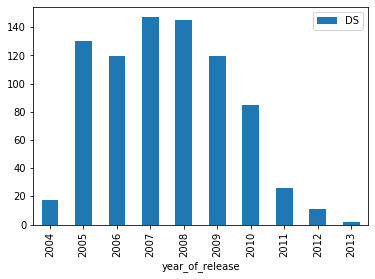

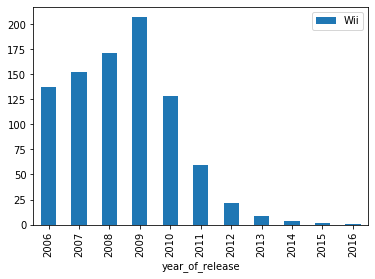

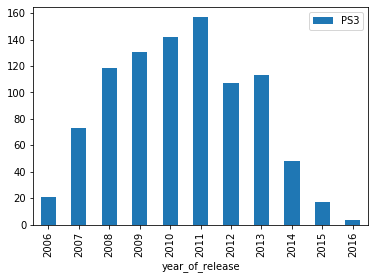

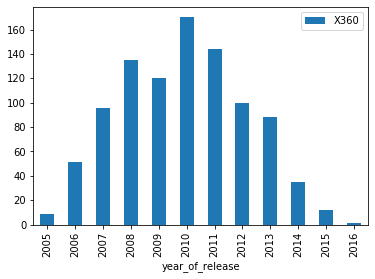

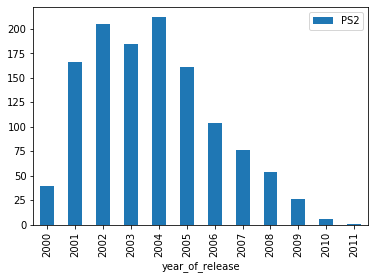

   platform  total_sales
21      3DS       257.81
22      PSP       289.53
23      GBA       312.88
24      PS4       314.14
25       PS       727.58
26       DS       802.76
27      Wii       891.18
28      PS3       931.34
29     X360       961.24
30      PS2      1233.56


In [12]:
games_data_year = games_data_year.query('year_of_release > 1990 or year_of_release == 1981')
#print(games_data_year['year_of_release'].value_counts().reset_index())

platform_sales = games_data_year.groupby(['platform'])['total_sales'].sum().sort_values().reset_index().tail(10)
platform_sales_by_year = games_data_year.groupby(['platform','year_of_release'])['total_sales'].sum().sort_values().reset_index()
top_10_list = list(platform_sales.loc[:,'platform'])
# data grouping, highlighting the top 10 sales platforms
print(top_10_list)
for pltfrm in top_10_list:
    platform_top_10_by_year = platform_sales_by_year[platform_sales_by_year['platform'] == pltfrm].sort_values(by='year_of_release')
    platform_top_10_by_year.plot(kind='bar', y='total_sales', x='year_of_release', label=pltfrm, legend=True) 
    plt.show()
# building histograms for platforms (years from sales)
print(platform_sales)


Based on the constructed graphs, it can be seen that, on average, platforms stay on the market for 7 years, therefore, we can assume that every 7 years there is a change in platform generations and it is necessary to consider the last 7 years, for the forecast for the next year

In [13]:
games_data_actual = games_data.query('year_of_release >= 2010') # selection of the last seven years
games_data_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5277 entries, 14 to 16714
Data columns (total 14 columns):
name               5277 non-null object
platform           5277 non-null object
year_of_release    5277 non-null int64
genre              5277 non-null object
na_sales           5277 non-null float64
eu_sales           5277 non-null float64
jp_sales           5277 non-null float64
other_sales        5277 non-null float64
critic_score       5277 non-null float64
user_score         5277 non-null float64
rating             5277 non-null object
age_rating         3113 non-null float64
total_sales        5277 non-null float64
sales_category     5277 non-null object
dtypes: float64(8), int64(1), object(5)
memory usage: 618.4+ KB


['PSP', 'WiiU', 'PC', 'DS', 'XOne', 'Wii', '3DS', 'PS4', 'X360', 'PS3']


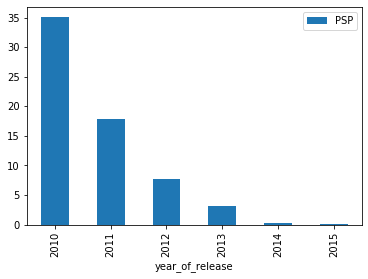

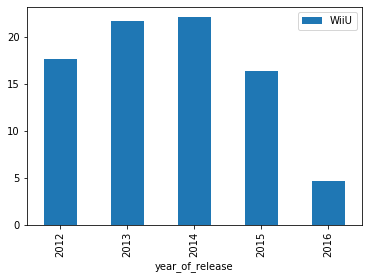

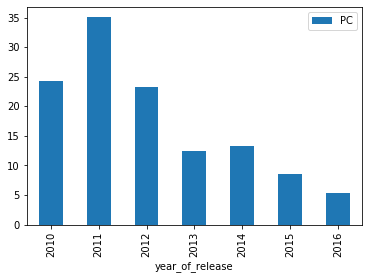

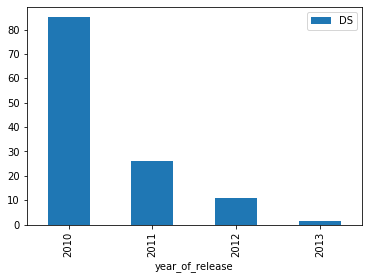

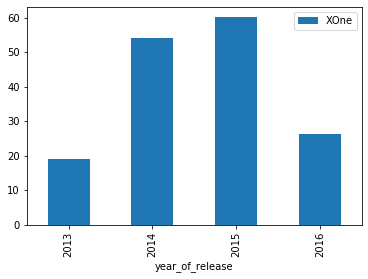

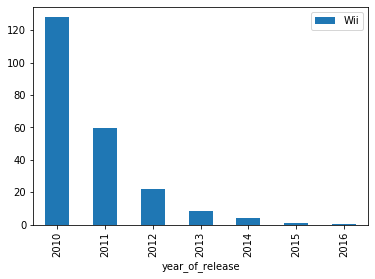

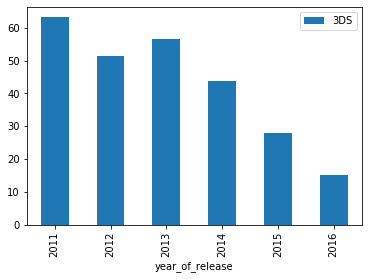

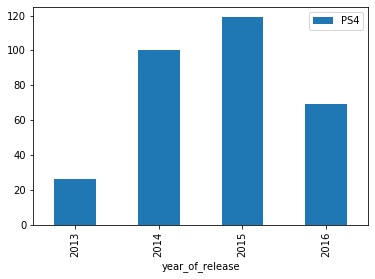

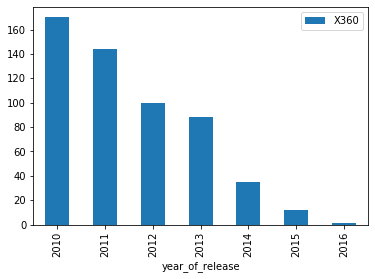

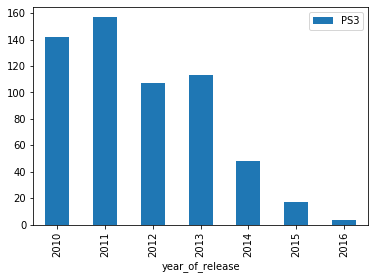

In [14]:
games_data_actual_sales = games_data_actual.groupby(['platform'])['total_sales']\
    .sum().sort_values().reset_index().tail(10)
games_sales_by_year = games_data_actual.groupby(['platform','year_of_release'])['total_sales'].sum().sort_values().reset_index()
top_10_list_new = list(games_data_actual_sales.loc[:,'platform'])
print(top_10_list_new)
for platform_new in top_10_list_new:
    platform_top_10_new = games_sales_by_year[games_sales_by_year['platform'] == platform_new].sort_values(by='year_of_release')
    platform_top_10_new.plot(kind='bar', y='total_sales', x='year_of_release', label=platform_new, legend=True) 
    plt.show()
# viewing dependencies for platforms, but already with a limitation by years



The 10 platforms have shown good earnings performance over the past 7 years, but only PS4 and XOne have maintained growth over the past two years, given that 2016 data is incomplete. Let's single out these 2 platforms

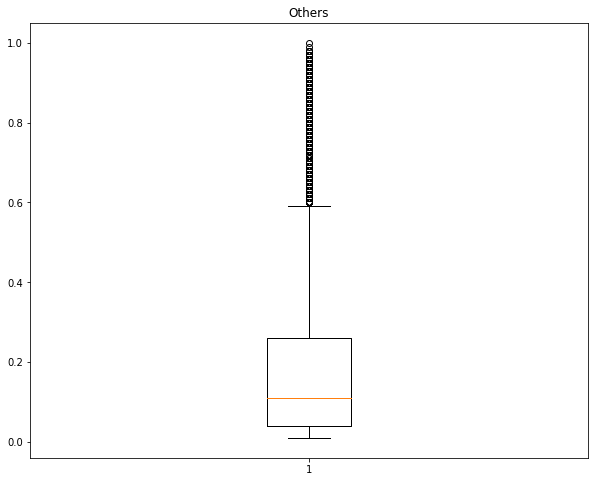

count    4196.000000
mean        0.193003
std         0.219301
min         0.010000
25%         0.040000
50%         0.110000
75%         0.260000
max         1.000000
Name: total_sales, dtype: float64


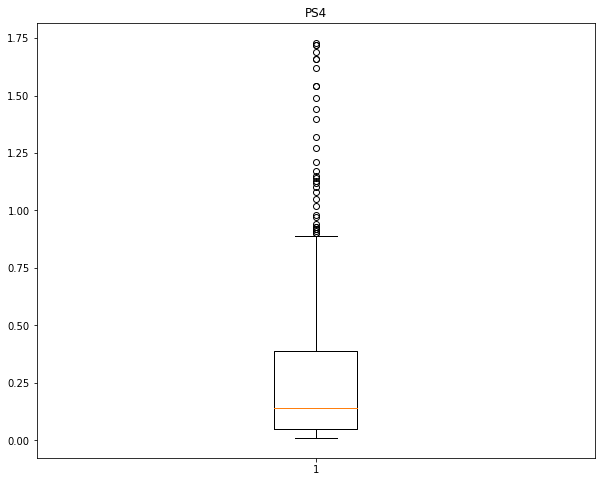

count    338.000000
mean       0.306213
std        0.384944
min        0.010000
25%        0.050000
50%        0.140000
75%        0.390000
max        1.730000
Name: total_sales, dtype: float64


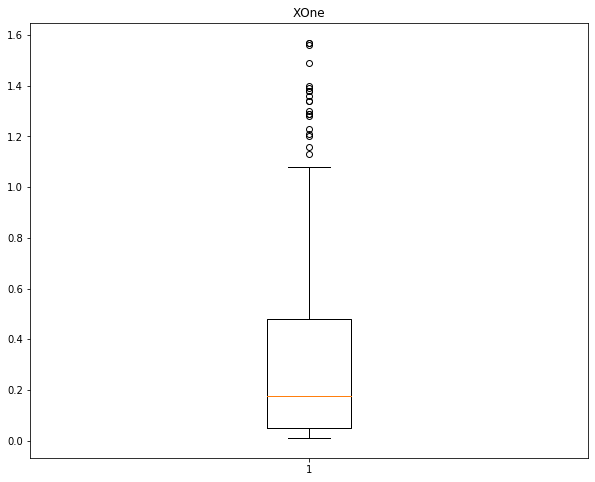

count    220.000000
mean       0.343227
std        0.403082
min        0.010000
25%        0.050000
50%        0.175000
75%        0.480000
max        1.570000
Name: total_sales, dtype: float64


In [12]:
games_others_platform = games_data_actual.query('platform != "PS4" & platform != "XOne" & total_sales < 1')

fig0, ax0 = plt.subplots(figsize=(10, 8))
ax0.set_title('Others')
ax0.boxplot(games_others_platform['total_sales'])
plt.show()
print(games_others_platform['total_sales'].describe())
# platform sales "mustache"
games_top_PS4_corrected = games_data_actual.query('platform == "PS4" & total_sales < 1.735')

fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.set_title('PS4')
ax1.boxplot(games_top_PS4_corrected['total_sales'])
plt.show()
print(games_top_PS4_corrected['total_sales'].describe())

games_top_XOne_corrected = games_data_actual.query('platform == "XOne" & total_sales < 1.6225')

fig2, ax2 = plt.subplots(figsize=(10, 8))
ax2.set_title('XOne')
ax2.boxplot(games_top_XOne_corrected['total_sales'])
plt.show()
print(games_top_XOne_corrected['total_sales'].describe())

- The difference between sales by games max and min on all platforms is more than 21 million.
- For PS4 platform : 14M difference
- For XOne platform: the difference is less than 7 million.

Limit sales values from above based on quantiles.

- For all platforms : average = 0.19 million
- For PS4 platform : Average = 0.31 million
- For XOne platform : average = 0.34 million

On average, it is more profitable to release a game on the XOne platform than on other platforms. But the PS4 platform has seen a larger number of games that have sold in large numbers.

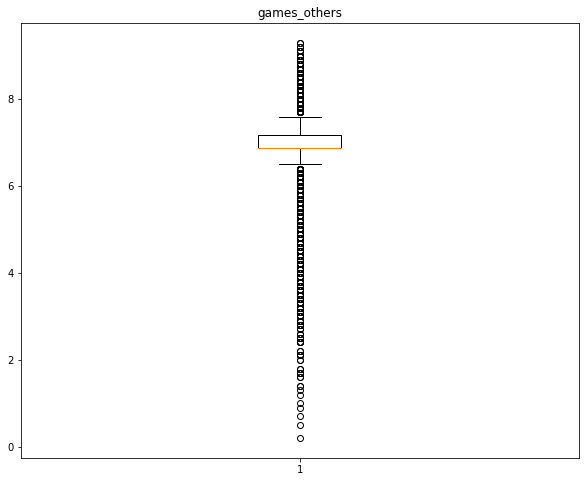

count    4638.000000
mean        6.831688
std         1.040934
min         0.200000
25%         6.867327
50%         6.887341
75%         7.175000
max         9.300000
Name: user_score, dtype: float64


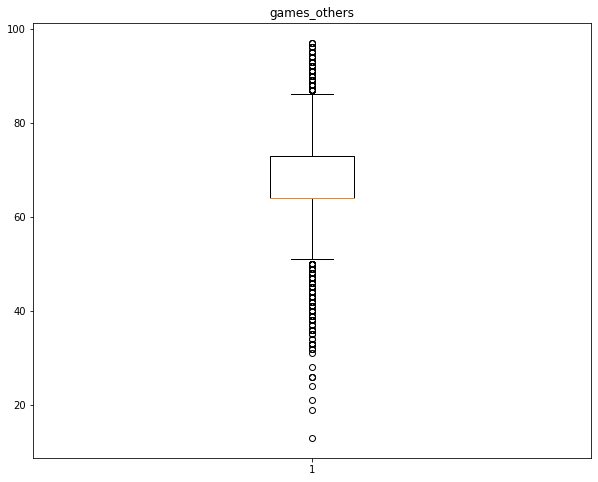

count    4638.000000
mean       67.452311
std         9.401752
min        13.000000
25%        63.974887
50%        64.085072
75%        73.000000
max        97.000000
Name: critic_score, dtype: float64


,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,age_rating,total_sales
year_of_release,1.000000,-0.083048,-0.042653,0.043241,-0.061941,0.052999,-0.054169,0.126361,-0.055739
na_sales,-0.083048,1.000000,0.798257,0.265763,0.789515,0.332991,0.036463,0.079354,0.933406
eu_sales,-0.042653,0.798257,1.000000,0.315316,0.950024,0.363408,0.028727,0.095777,0.929991
jp_sales,0.043241,0.265763,0.315316,1.000000,0.241259,0.151247,0.129846,-0.011776,0.473790
other_sales,-0.061941,0.789515,0.950024,0.241259,1.000000,0.352011,0.035440,0.108417,0.898967
critic_score,0.052999,0.332991,0.363408,0.151247,0.352011,1.000000,0.429052,0.090174,0.367911
user_score,-0.054169,0.036463,0.028727,0.129846,0.035440,0.429052,1.000000,0.063873,0.058703
age_rating,0.126361,0.079354,0.095777,-0.011776,0.108417,0.090174,0.063873,1.000000,0.087815
total_sales,-0.055739,0.933406,0.929991,0.473790,0.898967,0.367911,0.058703,0.087815,1.000000


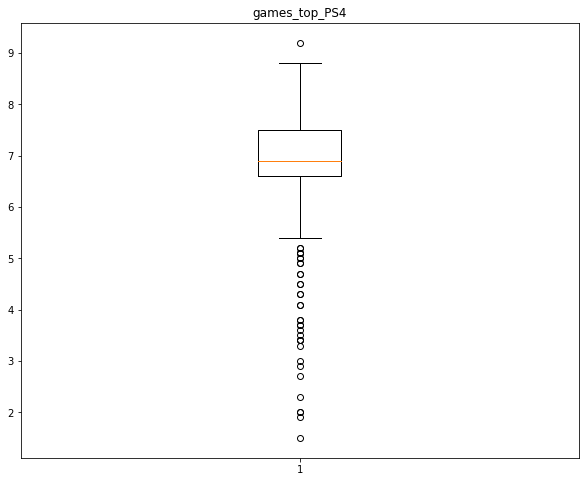

count    392.000000
mean       6.846546
std        1.195696
min        1.500000
25%        6.600000
50%        6.893670
75%        7.500000
max        9.200000
Name: user_score, dtype: float64


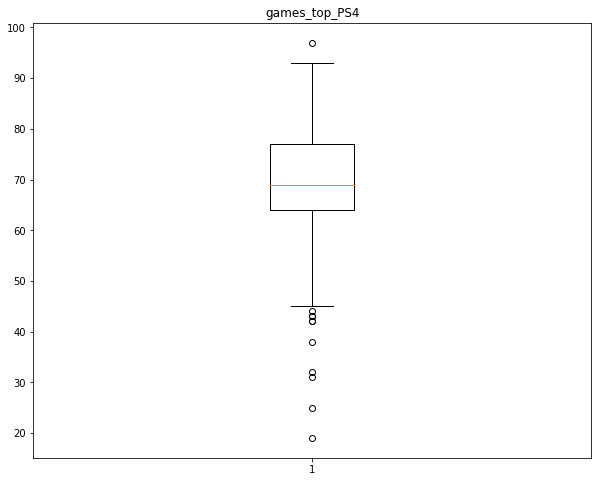

count    392.000000
mean      70.378225
std       10.669406
min       19.000000
25%       64.085072
50%       69.000000
75%       77.000000
max       97.000000
Name: critic_score, dtype: float64


,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,age_rating,total_sales
year_of_release,1.000000,-0.248961,-0.208306,-0.060993,-0.234796,-0.100238,0.118595,0.065413,-0.235032
na_sales,-0.248961,1.000000,0.785362,0.472981,0.944259,0.410657,0.001135,0.160032,0.928160
eu_sales,-0.208306,0.785362,1.000000,0.464563,0.944698,0.380469,-0.031655,0.112412,0.958157
jp_sales,-0.060993,0.472981,0.464563,1.000000,0.496467,0.262350,0.157302,0.291441,0.527129
other_sales,-0.234796,0.944259,0.944698,0.496467,1.000000,0.417982,-0.013332,0.144260,0.998051
critic_score,-0.100238,0.410657,0.380469,0.262350,0.417982,1.000000,0.514702,0.099224,0.418061
user_score,0.118595,0.001135,-0.031655,0.157302,-0.013332,0.514702,1.000000,0.204662,-0.010893
age_rating,0.065413,0.160032,0.112412,0.291441,0.144260,0.099224,0.204662,1.000000,0.150335
total_sales,-0.235032,0.928160,0.958157,0.527129,0.998051,0.418061,-0.010893,0.150335,1.000000


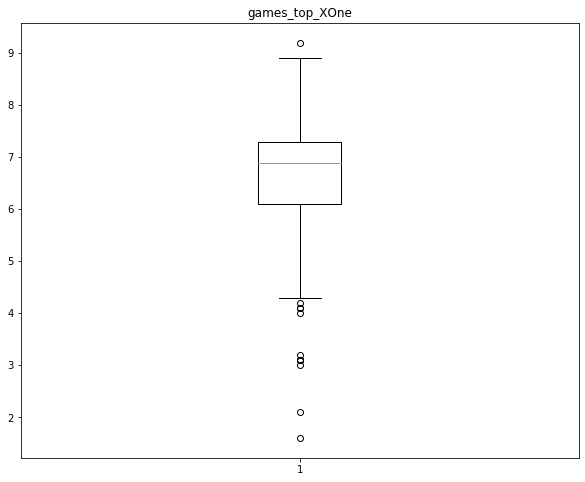

count    247.000000
mean       6.648620
std        1.207684
min        1.600000
25%        6.100000
50%        6.887341
75%        7.300000
max        9.200000
Name: user_score, dtype: float64


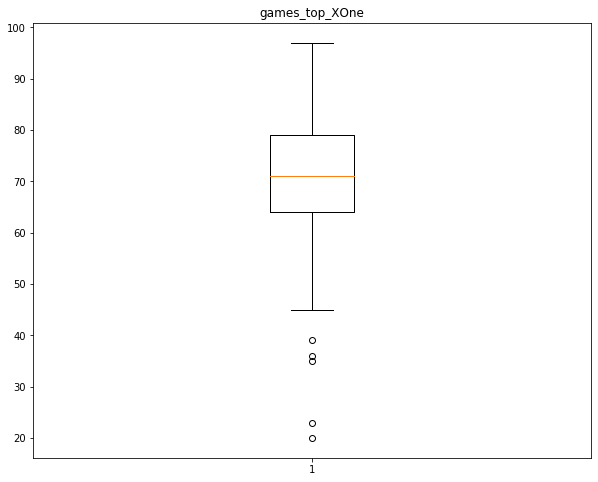

count    247.000000
mean      71.203261
std       11.415995
min       20.000000
25%       64.085072
50%       71.000000
75%       79.000000
max       97.000000
Name: critic_score, dtype: float64


,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,age_rating,total_sales
year_of_release,1.000000,-0.242667,-0.194925,-0.127050,-0.243414,0.006890,0.067157,0.060112,-0.239183
na_sales,-0.242667,1.000000,0.765367,0.425725,0.988088,0.418594,-0.058906,0.212703,0.970433
eu_sales,-0.194925,0.765367,1.000000,0.421071,0.852986,0.421798,-0.049079,0.130413,0.898045
jp_sales,-0.127050,0.425725,0.421071,1.000000,0.441717,0.223219,0.058876,0.130022,0.452701
other_sales,-0.243414,0.988088,0.852986,0.441717,1.000000,0.439043,-0.058340,0.206565,0.995238
critic_score,0.006890,0.418594,0.421798,0.223219,0.439043,1.000000,0.378171,0.118530,0.444511
user_score,0.067157,-0.058906,-0.049079,0.058876,-0.058340,0.378171,1.000000,0.144302,-0.058168
age_rating,0.060112,0.212703,0.130413,0.130022,0.206565,0.118530,0.144302,1.000000,0.197373
total_sales,-0.239183,0.970433,0.898045,0.452701,0.995238,0.444511,-0.058168,0.197373,1.000000


In [16]:
games_top_PS4 = games_data_actual.query('platform == "PS4"')
games_top_XOne = games_data_actual.query('platform == "XOne"')
games_others = games_data_actual.query('platform != "PS4" & platform != "XOne"')
# allocation of data by platform

columns_score = ('user_score','critic_score')

for i in columns_score:
    fig0, ax0 = plt.subplots(figsize=(10, 8))
    ax0.set_title('games_others')
    ax0.boxplot(games_others[i])
    plt.show()
    print(games_others[i].describe())
display(games_others.corr())
# "mustaches" for platforms according to users and critics
for i in columns_score:
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    ax2.set_title('games_top_PS4')
    ax2.boxplot(games_top_PS4[i])
    plt.show()
    print(games_top_PS4[i].describe())
display(games_top_PS4.corr())
    
for i in columns_score:
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    ax1.set_title('games_top_XOne')
    ax1.boxplot(games_top_XOne[i])
    plt.show()
    print(games_top_XOne[i].describe())
display(games_top_XOne.corr())

- For the PS4 platform, average critic rating = 70.4 out of 100 and users = 6.8 out of 10. Correlation coefficient between sales and ratings: for critics = 0.42, for users = - 0.01
- For the XOne platform, average critic rating = 71.2 out of 100 and users = 6.65 out of 10. Correlation coefficient between sales and ratings: for critics = 0.44, for users = - 0.06
- For other platforms, average critic rating = 67.5 out of 100 and users = 6.8 out of 10. Correlation coefficient between sales and ratings: for critics = 0.37, for users = 0.06

This shows that there is an average correlation between critic rating and sales, while there is no correlation between user ratings and sales.
For the rest of the platforms, the critics rating is also moderately correlated with sales, but slightly worse than the leading platforms, while users are not.

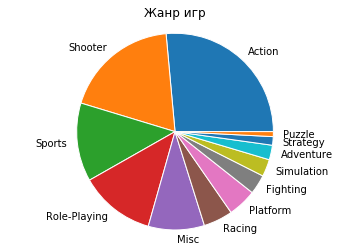

,genre,total_sales
0,Action,673.09
1,Shooter,479.74
2,Sports,328.39
3,Role-Playing,315.28
4,Misc,234.56
5,Racing,122.68
6,Platform,119.72
7,Fighting,81.59
8,Simulation,71.75
9,Adventure,61.00


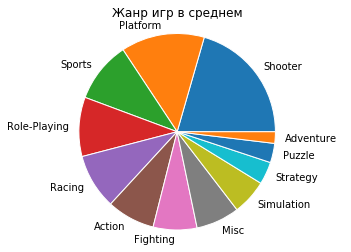

,genre,total_sales
0,Shooter,1.170098
1,Platform,0.782484
2,Sports,0.571113
3,Role-Playing,0.555070
4,Racing,0.517637
5,Action,0.450227
6,Fighting,0.410000
7,Misc,0.407222
8,Simulation,0.330645
9,Strategy,0.210824


In [19]:
#print(games_data_actual['genre'].value_counts())
genre_sales = games_data_actual.groupby('genre')['total_sales'].sum().sort_values(ascending=False).reset_index()

avg_genre_sales = games_data_actual.groupby('genre')['total_sales'].mean().sort_values(ascending=False).reset_index()

fig, ax = plt.subplots()
ax.set_title('Жанр игр')
ax.pie(genre_sales['total_sales'], labels=genre_sales['genre'], wedgeprops=dict(edgecolor='w'))
ax.axis("equal")
plt.show()

display(genre_sales)

fig1, ax1 = plt.subplots()
ax1.set_title('Жанр игр в среднем')
ax1.pie(avg_genre_sales['total_sales'], labels=avg_genre_sales['genre'], wedgeprops=dict(edgecolor='w'))
ax1.axis("equal")
plt.show()


display(avg_genre_sales)
# review of the most popular genres

The most popular genre for games is "Action", the same genre is the best-selling one. "Puzzle" is the most unpopular in terms of number of games and sales. In average sales by genre, the most popular genre is Shooter, action has shifted to the middle of the ranking.

In [23]:
regions_list = ('na_sales','eu_sales','jp_sales')

for i in regions_list:
    regions_platform = games_data_actual.groupby('platform')[i].sum().reset_index()
    sum_reg = regions_platform[i].sum()
    print('Сумма продаж в регионе', i, '{:.2f}'.format(sum_reg))
    regions_platform['part'] = regions_platform[i] / sum_reg
    display(regions_platform.sort_values(by='part', ascending=False).head(5))
    regions_genre = games_data_actual.groupby('genre')[i].sum().reset_index()
    regions_genre['part'] = regions_genre[i] / sum_reg
    display(regions_genre.sort_values(by='part', ascending=False).head(5))
    
#share of sales by region for genres and platforms

Сумма продаж в регионе na_sales 1130.41


,platform,na_sales,part
10,X360,334.18,0.295627
4,PS3,229.25,0.202803
8,Wii,121.20,0.107218
5,PS4,108.74,0.096195
11,XOne,93.12,0.082377


,genre,na_sales,part
0,Action,290.64,0.257110
8,Shooter,237.47,0.210074
10,Sports,156.81,0.138720
3,Misc,123.80,0.109518
7,Role-Playing,112.05,0.099123


Сумма продаж в регионе eu_sales 841.21


,platform,eu_sales,part
4,PS3,213.60,0.253920
10,X360,163.41,0.194256
5,PS4,141.09,0.167723
2,PC,68.82,0.081811
8,Wii,65.91,0.078351


,genre,eu_sales,part
0,Action,233.63,0.277731
8,Shooter,171.45,0.203814
10,Sports,116.84,0.138895
7,Role-Playing,75.48,0.089728
3,Misc,66.09,0.078565


Сумма продаж в регионе jp_sales 305.14


,platform,jp_sales,part
0,3DS,100.62,0.329750
4,PS3,59.26,0.194206
6,PSP,42.20,0.138297
1,DS,27.90,0.091433
7,PSV,21.84,0.071574


,genre,jp_sales,part
7,Role-Playing,103.54,0.339320
0,Action,72.20,0.236613
3,Misc,24.29,0.079603
4,Platform,15.81,0.051812
1,Adventure,15.67,0.051353


- For Europe and North America, the most popular platforms are X360 and PS3. In Japan, X360 is not the leader, they have big sales from the local manufacturer 3DS.
- Also for genres, for Europe and America in 1st place - Action, 2 - Shooter. In Japan, there is again a peculiarity, in the first place - Role-Playing. Most likely the difference between Europe, America and Japan is due to large differences in culture.


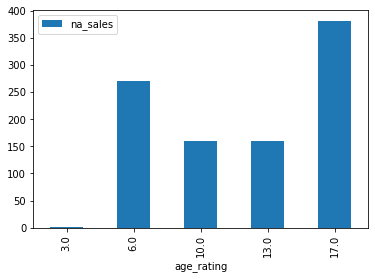

   age_rating  na_sales
0         3.0      1.13
1         6.0    271.15
2        10.0    159.38
3        13.0    160.81
4        17.0    382.22
            age_rating  na_sales
age_rating     1.00000   0.71727
na_sales       0.71727   1.00000


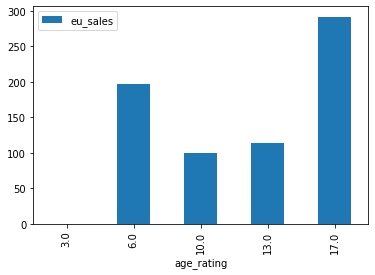

   age_rating  eu_sales
0         3.0      0.00
1         6.0    197.34
2        10.0     99.28
3        13.0    113.08
4        17.0    292.04
            age_rating  eu_sales
age_rating    1.000000  0.711568
eu_sales      0.711568  1.000000


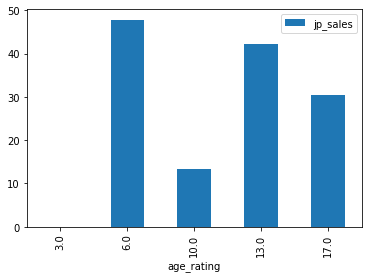

   age_rating  jp_sales
0         3.0      0.00
1         6.0     47.87
2        10.0     13.22
3        13.0     42.11
4        17.0     30.45
            age_rating  jp_sales
age_rating    1.000000  0.394897
jp_sales      0.394897  1.000000


In [24]:
age_games_data = games_data_actual.query('age_rating > 0')
    
for i in regions_list:
    age_games = age_games_data.groupby('age_rating')[i].sum().reset_index()
    age_games.plot(kind='bar', y=i, x='age_rating', legend=True) 
    #plt.bar(age_games['age_rating'], age_games[i], bins=(100))
    plt.show()
    print(age_games)
    print(age_games.corr())
# link between age rating and sales

For America and Europe, sales by age rating are similar, among games the leading place is occupied with a rating of 17+, and then there are games for children 6+. For Japan, 6+ games come first, followed by 13+. Therefore, in Japan, games are played mainly by children, and in the West (America + Europe) already teenagers and adults.

Let's test the hypotheses. Null hypothesis: the average user ratings of the XOne and PC platforms are the same, the alternative is not. To test hypotheses, we use the t-test of the hypothesis about the equality of the means of two general populations

In [25]:
games_top_PC_avg = games_data_actual.query('platform == "PC"')
games_top_XOne_avg = games_data_actual.query('platform == "XOne"')

alpha = 0.1
# hypothesis testing
results_platform = st.ttest_ind(games_top_PC_avg['user_score'], games_top_XOne_avg ['user_score'])
print('p-значение:', results_platform.pvalue) 

if (results_platform.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу для тарифов")
else:
    print("Не получилось отвергнуть нулевую гипотезу для тарифов")

p-значение: 0.6960430378350946
Не получилось отвергнуть нулевую гипотезу для тарифов


p-value: 0.6960430378350946

Failed to reject null hypothesis for tariffs

The average user ratings for PC and XOne games were the same.

Null Hypothesis: Average user ratings for the Action and Sports genres are equal.

In [18]:
games_top_action = games_data_actual.query('genre == "Action"')
games_top_sports = games_data_actual.query('genre == "Sports"')

alpha = 0.1
# проверка гипотезы
results_genre = st.ttest_ind(games_top_action['user_score'], games_top_sports ['user_score'])
print('p-значение:', results_genre.pvalue) 

if (results_genre.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу для тарифов")
else:
    print("Не получилось отвергнуть нулевую гипотезу для тарифов")

p-значение: 1.3090925162637772e-18
Отвергаем нулевую гипотезу для тарифов


p-value: 1.3090925162637772e-18

Rejecting the Null Hypothesis for Tariffs

The average user ratings for the Action and Sports genres are unequal.

### Conclusion 

Data preprocessing was carried out, gaps were filled in, data were categorized.

The period for which the platforms go through their rise and fall is singled out, it is equal to 7 years. It was the last 7 years that were considered for further data analysis.

Two promising platforms have been identified that will dominate the gaming industry in the near future in the whole world - these are PS4 and XOne. For these platforms, there is a high average value of game sales, more than for all platforms by almost 2 times ( PS4 = 0.31 million, XOne = 0.34 million, for all other platforms = 0.19)

Ratings of games, both from users and from critics, are weakly dependent on the chosen platforms. At the same time, there is a correlation between sales and ratings from critics, for all platforms the dependence is average (correlation coefficient from 0.37 to 0.44)

The most popular genres have been identified, for North America and Europe they are Action and Shooter. For the Japanese market, this is Role-Playing.
However, this is not the only feature of the Japanese market, at the moment the most popular platform for Japan is the 3DS, from Nintendo (Local manufacturer). And for the Western world, by far the most profitable platforms are from the same manufacturers that produce the PS4 and XOne platforms (X360 and PS3 platforms are popular)

The age rating has little effect on sales in the West and slightly worse in Japan.

### Results: ###

The average user for America and Europe is similar but different from Japan.

For America: the most popular platform is X360, the genre is Action. In second place is PS3, the second most popular genre is Shooter. Top selling games rated 17+

For Europe: The most popular platform is PS3, the genre is Action. In second place is the X360, the second most popular genre is Shooter. Top selling games rated 17+

For Japan: the most popular platform is 3DS, the genre is Role-Playing. In second place is PS3, the second most popular genre is Action. Top selling games rated 6+


2 hypotheses were tested. The first - the average user ratings for XOne and PC are equal, turned out to be correct. The second - the average user ratings for the Action and Sports genres are equal, turned out to be wrong.
